In [1]:
import os
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
import tensorflow.compat.v1 as tfc

from csv import reader
from tqdm import tqdm
from PIL import Image, ImageOps

import audio_data_gen as adg

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()

Num GPUs Available:  1
Found GPU at: /device:GPU:0


False

In [3]:
LIB = "adj_pic"
MAX_SIZE = (962,962)
BATCH_SIZE = 64

## Pipeline

In [4]:
RAND = random.randint(0, 100)
@tf.function
def img_to_arr(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float16)/255
    s = tf.shape(image)[1]
    image = tf.reshape(image, [s,MAX_SIZE[0],3])
    output = image[RAND]
    return output,output

In [5]:
file_list = glob.glob(f"{LIB}/*.jpg")

In [6]:
ds = tf.data.Dataset.list_files(file_list).map(img_to_arr,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
ds = ds.take(32000)
ds = ds.batch(batch_size= BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## Modelling

In [7]:
from keras import backend as K
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist

In [8]:
img_height = MAX_SIZE[0]
num_channels = 3
latent_dim = 1443
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [9]:
encoder_input = Input(shape=(img_height,num_channels))

encoder_conv = Conv1D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv1D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [10]:
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
conv_shape = K.int_shape(encoder_conv)
conv_shape

(None, 481, 16)

In [11]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2]))(decoder)
decoder_conv = Conv1DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv1DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv1DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [12]:
encoder = Model(encoder_input, latent_space)
encoder.summary()
decoder = Model(decoder_input, decoder_conv)
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 962, 3)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 481, 16)      160         ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 7696)         0           ['conv1d_1[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 1443)         11106771    ['flatten[0][0]']                
                                                                                              

In [13]:
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 962, 3)]          0         
                                                                 
 model (Functional)          (None, 1443)              22213702  
                                                                 
 model_1 (Functional)        (None, 962, 3)            11113491  
                                                                 
Total params: 33,327,193
Trainable params: 33,327,193
Non-trainable params: 0
_________________________________________________________________


In [14]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [15]:
history = vae.fit(ds, epochs=5, validation_data=ds)

KeyboardInterrupt: 

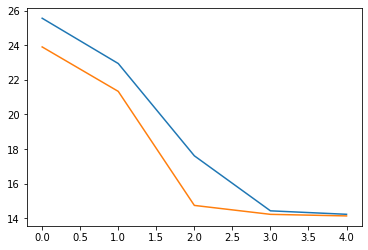

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [154]:
vae.save('vae')
decoder.save('dec')
encoder.save('enc')

INFO:tensorflow:Assets written to: vae\assets
INFO:tensorflow:Assets written to: dec\assets
INFO:tensorflow:Assets written to: enc\assets


### Gen new image from audio

In [16]:
decoder = tf.keras.models.load_model('dec')
decoder.compile(optimizer='adam', loss=kl_reconstruction_loss)

audio = "motive.wav"
name = audio.split(".")[0]
adg.extract(audio)

D:\Oliver\Music_to_Art_GAN\audio_data_gen.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.0021078  0.00191791 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)
D:\Oliver\Music_to_Art_GAN\audio_data_gen.py:29: FutureWarning: Pass y=[0.         0.         0.         ... 0.0021078  0.00191791 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)


In [20]:
FILE = glob.glob(f"{audio}_*_1443.csv")[0]
with open(FILE) as csv_file:
    csv_reader = reader(csv_file)
    head = next(csv_reader)
    
    arr = []
    for row in tqdm(csv_reader):
        row = np.resize(np.expand_dims(np.array(row),axis = 0),(1,1443))

        pred_im = decoder.predict((row,))
        arr.append(pred_im)

0it [00:00, ?it/s]C:\Users\Oliver\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
5310it [00:32, 162.60it/s]


In [148]:
arr_n = np.squeeze(np.array(arr)*255,axis =1)
img = Image.fromarray(arr_n , 'RGB')
img.save(f"{name}.jpg")


KeyboardInterrupt

